Cell 1: Install Dependencies

!pip install archspec==0.2.3 \
asttokens==2.4.1 \
boltons==23.0.0 \
Brotli==1.0.9 \
charset-normalizer==2.0.4 \
colorama==0.4.6 \
comm==0.2.2 \
cryptography==42.0.5 \
decorator==4.4.2 \
distro==1.9.0 \
executing==2.0.1 \
frozendict==2.4.2 \
idna==3.7 \
jedi==0.19.1 \
jsonpatch==1.33 \
jsonpointer==2.1 \
nest-asyncio==1.6.0 \
packaging==23.2 \
parso==0.8.4 \
platformdirs==4.2.1 \
pluggy==1.0.0 \
pure-eval==0.2.2 \
pycosat==0.6.6 \
pycparser==2.21 \
Pygments==2.18.0 \
PySocks==1.7.1 \
requests==2.32.3 \
ruamel.yaml==0.17.21 \
stack-data==0.6.3 \
tqdm==4.66.4 \
traitlets==5.14.3 \
truststore==0.8.0 \
urllib3==2.2.2 \
zstandard==0.22.0 \
ptflops==0.7.4 \
pykan


Cell 2: Imports & Device Configuration

In [3]:
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from ptflops import get_model_complexity_info

from sklearn.metrics import confusion_matrix

from kan import KAN  # Import your KAN implementation from pykan
from tqdm import tqdm
from torch.amp import GradScaler

# Decide CPU vs. GPU usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_type = 'cuda' if torch.cuda.is_available() else 'cpu'
use_amp = torch.cuda.is_available()  # We'll use Automatic Mixed Precision if on GPU
print(f'Using device: {device}')


Using device: cpu


Cell 3: Dataset Transforms & DataLoaders

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),              # Convert PIL image to Tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize MNIST mean/std
])

# Download MNIST dataset (train/test). Store in './data'
train_dataset = datasets.MNIST(root='./data', train=True,  download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoader for training and test sets
# Large batch_size (4096/1024) to speed up training on GPU; adjust if memory is an issue
train_loader = DataLoader(train_dataset, batch_size=4096, shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=1024, shuffle=False, num_workers=2, pin_memory=True)


Cell 4: Define the MLP Class

In [5]:
class MLP(nn.Module):
    def __init__(self, width):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(width) - 1):
            layers.append(nn.Linear(width[i], width[i+1]))
            if i < len(width) - 2:
                layers.append(nn.ReLU())
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


Cell 5: Instantiate MLP & KAN Models

In [6]:
# Example minimal architecture: [784, 8, 10]
modelMLP = MLP(width=[784, 8, 10]).to(device)

# KAN with same widths, plus TReLU config
modelKAN = KAN(width=[784, 8, 10], grid=3, k=2, seed=42, device=device)


checkpoint directory created: ./model
saving model version 0.0


Cell 6: Define Loss & Optimizers

In [7]:
criterion = torch.nn.CrossEntropyLoss()
optimizerMLP = torch.optim.Adam(modelMLP.parameters(), lr=0.001, weight_decay=1e-4)
optimizerKAN = torch.optim.Adam(modelKAN.parameters(), lr=0.0005)


Cell 7: Main Training & Evaluation Loop

Epoch [1/1]: 100%|██████████| 15/15 [00:57<00:00,  3.80s/it]


Epoch [1/1] | MLP Loss: 2.0243 | MLP Test Acc: 47.41% | KAN Loss: 2.1901 | KAN Test Acc: 27.60% | Epoch Time: 67.98s


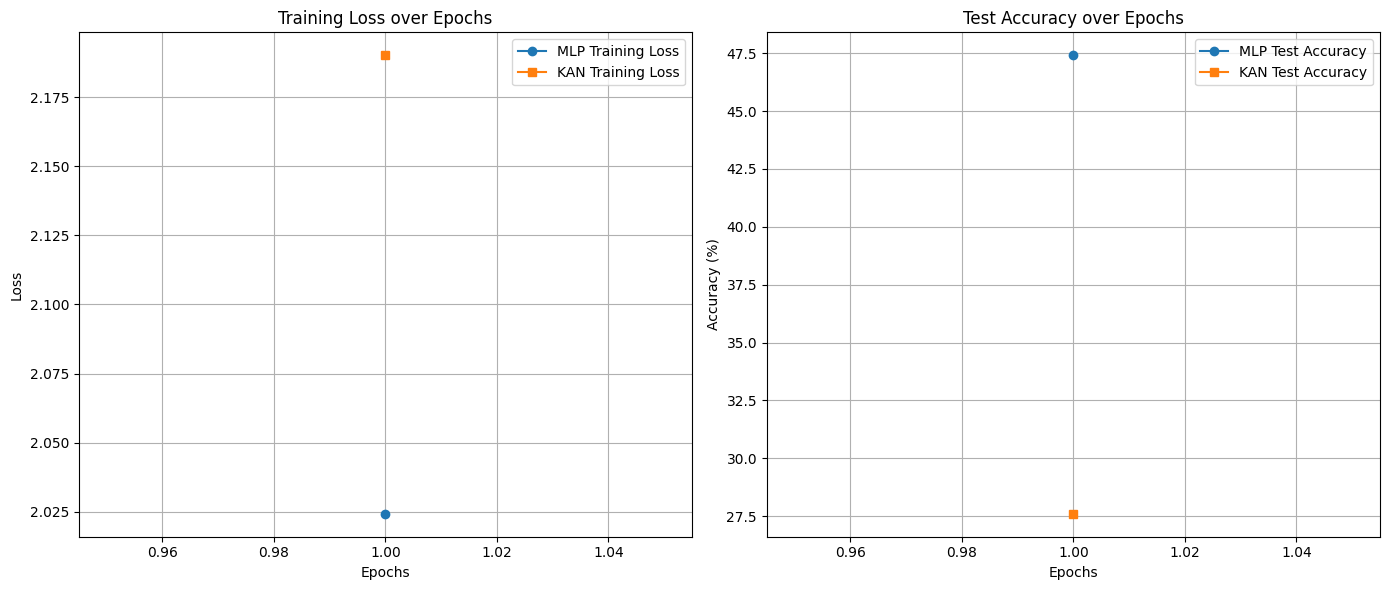

In [8]:
use_amp = torch.cuda.is_available()

scalerMLP = GradScaler(device='cuda', enabled=use_amp)
scalerKAN = GradScaler(device='cuda', enabled=use_amp)

train_losses_MLP = []
train_losses_KAN = []
test_accuracies_MLP = []
test_accuracies_KAN = []

num_epochs = 1  # For quick testing; set higher for better training

for epoch in range(num_epochs):
    start_time = time.time()

    # Switch models to training mode
    modelMLP.train()
    modelKAN.train()

    running_loss_MLP = 0.0
    running_loss_KAN = 0.0
    correct_MLP = 0
    correct_KAN = 0
    total = 0

    # ---- TRAINING LOOP ----
    for images, labels in tqdm(train_loader, desc=f'Epoch [{epoch+1}/{num_epochs}]'):
        # Flatten MNIST images (N, 1, 28, 28) -> (N, 784)
        images = images.view(images.size(0), -1).to(device)
        labels = labels.to(device)

        # MLP forward/backward
        optimizerMLP.zero_grad()
        with torch.autocast(device_type=device_type, enabled=use_amp):
            outputs_MLP = modelMLP(images)
            loss_MLP = criterion(outputs_MLP, labels)
        scalerMLP.scale(loss_MLP).backward()
        scalerMLP.step(optimizerMLP)
        scalerMLP.update()

        running_loss_MLP += loss_MLP.item()
        _, predicted_MLP = torch.max(outputs_MLP, 1)
        correct_MLP += (predicted_MLP == labels).sum().item()

        # KAN forward/backward
        optimizerKAN.zero_grad()
        with torch.autocast(device_type=device_type, enabled=use_amp):
            outputs_KAN = modelKAN(images)
            loss_KAN = criterion(outputs_KAN, labels)
        scalerKAN.scale(loss_KAN).backward()
        scalerKAN.step(optimizerKAN)
        scalerKAN.update()

        running_loss_KAN += loss_KAN.item()
        _, predicted_KAN = torch.max(outputs_KAN, 1)
        correct_KAN += (predicted_KAN == labels).sum().item()

        total += labels.size(0)

    # Average losses over the training set
    avg_loss_MLP = running_loss_MLP / len(train_loader)
    avg_loss_KAN = running_loss_KAN / len(train_loader)
    train_losses_MLP.append(avg_loss_MLP)
    train_losses_KAN.append(avg_loss_KAN)

    # ---- EVALUATION LOOP ----
    modelMLP.eval()
    modelKAN.eval()
    correct_MLP_test = 0
    correct_KAN_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(images.size(0), -1).to(device)
            labels = labels.to(device)

            # MLP prediction
            outputs_MLP = modelMLP(images)
            _, predicted_MLP = torch.max(outputs_MLP, 1)
            correct_MLP_test += (predicted_MLP == labels).sum().item()

            # KAN prediction
            outputs_KAN = modelKAN(images)
            _, predicted_KAN = torch.max(outputs_KAN, 1)
            correct_KAN_test += (predicted_KAN == labels).sum().item()

            total_test += labels.size(0)

    # Compute test-set accuracy
    test_accuracy_MLP = 100 * correct_MLP_test / total_test
    test_accuracy_KAN = 100 * correct_KAN_test / total_test
    test_accuracies_MLP.append(test_accuracy_MLP)
    test_accuracies_KAN.append(test_accuracy_KAN)

    epoch_time = time.time() - start_time
    print(f'Epoch [{epoch+1}/{num_epochs}] '
          f'| MLP Loss: {avg_loss_MLP:.4f} | MLP Test Acc: {test_accuracy_MLP:.2f}% '
          f'| KAN Loss: {avg_loss_KAN:.4f} | KAN Test Acc: {test_accuracy_KAN:.2f}% '
          f'| Epoch Time: {epoch_time:.2f}s')

# ---- Plot Loss & Accuracy ----
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses_MLP, label='MLP Training Loss', marker='o')
plt.plot(range(1, num_epochs+1), train_losses_KAN, label='KAN Training Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), test_accuracies_MLP, label='MLP Test Accuracy', marker='o')
plt.plot(range(1, num_epochs+1), test_accuracies_KAN, label='KAN Test Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Cell 8: Additional Functionality

In [ ]:
def feature_importance(kan_model):
    """
    Sums absolute spline coefficients for the first KAN layer and plots a bar graph.
    WARNING: This depends on the internal KAN structure (here we assume 'layers[0].splines').
    """
    importance = torch.abs(kan_model.act_fun[0].coef).sum(dim=(0, 1))
    plt.figure(figsize=(10,4))
    plt.bar(range(importance.size(0)), importance.cpu().detach().numpy())
    plt.title('Input Feature Importance (KAN)')
    plt.xlabel('Pixel Position')
    plt.ylabel('Importance')
    plt.show()

feature_importance(modelKAN)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

mlp_params = count_parameters(modelMLP)
kan_params = count_parameters(modelKAN)

print(f"MLP Parameters: {mlp_params:,}")
print(f"KAN Parameters: {kan_params:,}")

# 4 bytes per float32 parameter
print(f"MLP Memory: {mlp_params * 4 / 1e6:.2f} MB")
print(f"KAN Memory: {kan_params * 4 / 1e6:.2f} MB")

with torch.no_grad():
    # MLP Inference Timing
    start_infer_mlp = time.time()
    for images, labels in test_loader:
        images = images.view(images.size(0), -1).to(device)
        _ = modelMLP(images)
    mlp_infer_time = time.time() - start_infer_mlp

    # KAN Inference Timing
    start_infer_kan = time.time()
    for images, labels in test_loader:
        images = images.view(images.size(0), -1).to(device)
        _ = modelKAN(images)
    kan_infer_time = time.time() - start_infer_kan

print(f"MLP Inference Time (total over test set): {mlp_infer_time:.4f}s")
print(f"KAN Inference Time (total over test set): {kan_infer_time:.4f}s")

if device.type == 'cuda':
    print(f"GPU Memory Allocated: {torch.cuda.max_memory_allocated() / 1e9:.2f} GB")

def plot_confusion_matrix(model, loader, model_name="Model"):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.view(images.size(0), -1).to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(modelMLP, test_loader, "MLP")
plot_confusion_matrix(modelKAN, test_loader, "KAN")

def plot_weights(model, title):
    weights = []
    for param in model.parameters():
        if param.dim() > 1:  # Skip biases
            weights.extend(param.flatten().cpu().detach().numpy())
    plt.hist(weights, bins=50, alpha=0.6)
    plt.title(f'Weight Distribution: {title}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

plot_weights(modelMLP, "MLP")
plot_weights(modelKAN, "KAN")

def calculate_flops(model):
    dummy_input = torch.randn(1, 784).to(device)
    macs, params = get_model_complexity_info(
        model, (784,), as_strings=False, print_per_layer_stat=False
    )
    return macs

mlp_flops = calculate_flops(modelMLP)
kan_flops = calculate_flops(modelKAN)
print(f"MLP FLOPs: {mlp_flops:,}")
print(f"KAN FLOPs: {kan_flops:,}")

def show_predictions(model, loader, num_images=5):
    model.eval()
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images.view(images.size(0), -1))
            _, preds = torch.max(outputs, 1)
            for i in range(num_images):
                axes[i].imshow(images[i].cpu().squeeze(), cmap='gray')
                axes[i].set_title(f'Pred: {preds[i].item()}')
                axes[i].axis('off')
            break
    plt.show()

show_predictions(modelMLP, test_loader)  # Example for MLP
show_predictions(modelKAN, test_loader)  # Example for KAN

AttributeError: 'MultKAN' object has no attribute 'layers'